In [644]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


## Define constans and functions

In [645]:
locations = ["A", "B", "C"]
features_order = []
LAGGED_COLUMNS_TO_KEEP = [
    'direct_rad:W_lag_1h', 
    'direct_rad:W_lag_forward_1h', 
    'clear_sky_rad:W_lag_1h', 
    'clear_sky_rad:W_lag_forward_1h', 
    'diffuse_rad:W_lag_1h', 
    'diffuse_rad:W_lag_forward_1h', 
    'direct_rad_1h:J_lag_1h', 
    'direct_rad_1h:J_lag_forward_1h', 
    'is_in_shadow:idx_lag_1h', 
    'is_in_shadow:idx_lag_forward_1h', 
    'clear_sky_energy_1h:J_lag_1h', 
    'clear_sky_energy_1h:J_lag_forward_1h', 
    'effective_cloud_cover:p_lag_1h', 
    'effective_cloud_cover:p_lag_forward_1h', 
    'visibility:m_lag_1h', 
    'visibility:m_lag_forward_1h', 
    'total_cloud_cover:p_lag_1h', 
    'total_cloud_cover:p_lag_forward_1h', 


    # 'direct_rad:W_lag_2h', 
    # 'direct_rad:W_lag_forward_2h', 
    # 'clear_sky_rad:W_lag_2h', 
    # 'clear_sky_rad:W_lag_forward_2h', 
    # 'diffuse_rad:W_lag_2h', 
    # 'diffuse_rad:W_lag_forward_2h', 
    # 'direct_rad_1h:J_lag_2h', 
    # 'direct_rad_1h:J_lag_forward_2h', 
    # 'is_in_shadow:idx_lag_2h', 
    # 'is_in_shadow:idx_lag_forward_2h', 
    # 'clear_sky_energy_1h:J_lag_2h', 
    # 'clear_sky_energy_1h:J_lag_forward_2h', 
    # 'effective_cloud_cover:p_lag_2h', 
    # 'effective_cloud_cover:p_lag_forward_2h', 
    # 'visibility:m_lag_2h', 
    # 'visibility:m_lag_forward_2h', 
    # 'total_cloud_cover:p_lag_2h', 
    # 'total_cloud_cover:p_lag_forward_2h', 

    # 'direct_rad:W_lag_3h', 
    # 'direct_rad:W_lag_forward_3h', 
    # 'clear_sky_rad:W_lag_3h', 
    # 'clear_sky_rad:W_lag_forward_3h', 
    # 'diffuse_rad:W_lag_3h', 
    # 'diffuse_rad:W_lag_forward_3h', 
    # 'direct_rad_1h:J_lag_3h', 
    # 'direct_rad_1h:J_lag_forward_3h', 
    # 'is_in_shadow:idx_lag_3h', 
    # 'is_in_shadow:idx_lag_forward_3h', 
    # 'clear_sky_energy_1h:J_lag_3h', 
    # 'clear_sky_energy_1h:J_lag_forward_3h', 
    # 'effective_cloud_cover:p_lag_3h', 
    # 'effective_cloud_cover:p_lag_forward_3h', 
    # 'visibility:m_lag_3h', 
    # 'visibility:m_lag_forward_3h', 
    # 'total_cloud_cover:p_lag_3h', 
    # 'total_cloud_cover:p_lag_forward_3h'
]

CUSTOM_COLUMNS_TO_KEEP = [
    "hour_cos",
    "hour_sin",
    "month_sin",
    "month_cos",
    "day-of-year",
]

WEATHER_FEATURES = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
]


COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
     "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    # "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    # "location_A",
    # "location_B",
    # "location_C",
    # "date_calc",
    "pv_measurement",
] + CUSTOM_COLUMNS_TO_KEEP  +  LAGGED_COLUMNS_TO_KEEP

TEST_COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    # "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    # "location_A",
    # "location_B",
    # "location_C",
    # "date_calc",
    # "pv_measurement",
] + CUSTOM_COLUMNS_TO_KEEP + LAGGED_COLUMNS_TO_KEEP



def create_weather_lagged_features(df, weather_features):
    # Choose the weather features for which you want to create lagged versions
    for feature in weather_features:
        # Assuming hourly data, adjust the lags for your specific dataset
        # Creating lagged features for 1 hour, 1 day, and 1 week
        df[f'{feature}_lag_1h'] = df[feature].shift(1)
        # df[f'{feature}_lag_2h'] = df[feature].shift(2)
        # df[f'{feature}_lag_3h'] = df[feature].shift(3)

        df[f'{feature}_lag_forward_1h'] = df[feature].shift(-1)
        # df[f'{feature}_lag_forward_2h'] = df[feature].shift(-2)
        # df[f'{feature}_lag_forward_3h'] = df[feature].shift(-3)
        # df[f'{feature}_lag_24h'] = df[feature].shift(24*4)
        # df[f'{feature}_lag_168h'] = df[feature].shift(24 * 7 * 4 * 365)
        # df[f'{feature}_front_lag_1h'] = df[feature].shift(-4)
        # df[f'{feature}_front_lag_24h'] = df[feature].shift(-24*4)


    # Handling edges by filling NaNs with appropriate values or dropping them
    # You may choose to fill with zeroes or interpolate, based on what makes more sense for your data
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill
    
    return df


def create_lagged_features(df, column_name='pv_measurement'):
    # Assuming 'date_forecast' is the datetime column used for sorting

    df[f'{column_name}_prev_month'] = df[column_name].shift(24*7) # previous week

    # For yearly lag, you would need to calculate the number of observations per year
    # If the data is not consistent (leap years, etc.), you may need a more complex method
    # Here's a simple version assuming 365 days a year:
    df[f'{column_name}_prev_year'] = df[column_name].shift(24*365) # previous year
    df[f'{column_name}_2years_ago'] = df[column_name].shift(24*365*2) # next year

    # Handling edges by filling NaNs with appropriate values or dropping them
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill

    return df


## Clean data 

In [646]:
def generate_and_save_engineered_features(estimated_parquet_file=None, output_parquet_file="engineered_data.parquet"):
    # Load main dataset, observed dataset, and target dataset
    df_merged= pd.read_parquet(estimated_parquet_file)

    print(df_merged.head())


    # Feature Engineering
    df_merged = feature_engineering(df_merged)

    # Save the engineered data
    df_merged.to_parquet(output_parquet_file)
    print(f"Engineered data saved to {output_parquet_file}")


def feature_engineering(df_merged):
    
    # 1. Time-based Features
    # df_merged['hour'] = df_merged['date_forecast'].dt.hour
    # df_merged['month'] = df_merged['date_forecast'].dt.month
    # df_merged['weekday'] = df_merged['date_forecast'].dt.weekday

    # Sinusoidal transformations for cyclical time features
    # df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
    # df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)
    # df_merged['month_sin'] = np.sin(2 * np.pi * df_merged['month'] / 12)
    # df_merged['month_cos'] = np.cos(2 * np.pi * df_merged['month'] / 12)
    # df_merged['weekday_sin'] = np.sin(2 * np.pi * df_merged['weekday'] / 7)
    # df_merged['weekday_cos'] = np.cos(2 * np.pi * df_merged['weekday'] / 7)

    # Binning
    # bins = [-90, 0, 45, 90]
    # labels = ['1', '2', '3']
    # df_merged['sun_elevation_binned'] = pd.cut(df_merged['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)


    return df_merged

for location in locations:
    estimated_parquet_file_test = f"data/{location}/X_test_estimated.parquet"
    output_file_test = f"cleaned_data/{location}/X_test_engineered.parquet"
    generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file_test, output_parquet_file=output_file_test)
    estimated_parquet_file = f"data/{location}/X_train_estimated.parquet"
    observed_parquet_file = f"data/{location}/X_train_observed.parquet"
    target_parquet_file = f"data/{location}/train_targets.parquet"
    output_file = f"cleaned_data/{location}/X_train_engineered.parquet"
    generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file, output_parquet_file=output_file)


            date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1 2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2 2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3 2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4 2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.286            912.700012                    0.0   
1                1.287            912.700012                    0.0   
2                1.287            912.700012                    0.0   
3                1.287            912.700012                    0.0   
4                1.287                   NaN                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1041.199951              0.0      271.70001

## Prepare data


In [647]:
def add_custom_fields(df):
     df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
     df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

     df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['day-of-year'] = df['date_forecast'].dt.dayofyear
     return df

def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

In [648]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a dictionary to hold the scalers for each location
scalers = {}

def prepare_data(location):
    # Load data
    scaling = True  # Set scaling to True to enable individual scaling for each location
    global scalers

    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")

    # Combine observed and estimated datasets
    df_combined = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")

    df_combined = add_custom_fields(df_combined)
    df_combined.set_index('date_forecast', inplace=True)
    df_merged = df_combined.resample('1H').mean().interpolate(method="linear")

    # Merge with target data
    df_merged = pd.merge(df_merged, df_target, left_on="date_forecast", right_on="time", how="inner")
    
    # One-hot encoding for location
   
    # df_merged['location'] = location
    # df_merged['location_A'] = (df_merged['location'] == 'A').astype(int)
    # df_merged['location_B'] = (df_merged['location'] == 'B').astype(int)
    # df_merged['location_C'] = (df_merged['location'] == 'C').astype(int)
    # df_merged.drop('location', axis=1, inplace=True)
    df_merged = create_weather_lagged_features(df_merged, WEATHER_FEATURES)
    df_merged = df_merged[COLUMNS_TO_KEEP]
    df_merged = remove_outliers(df_merged)
    
    y = df_merged["pv_measurement"]
    X = df_merged.drop("pv_measurement", axis=1)
    
    # Treat location as a categorical feature by converting it to a category type
    X['location'] = location
    X['location'] = X['location'].astype(str)  # Convert to string if 'location' is not an int
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype(str)
    X['is_day:idx'] = X['is_day:idx'].astype(str)
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        X[column] = X[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in X[column].cat.categories:
            X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        X[column] = X[column].fillna('missing')
    X['location'] = X['location'].astype('category')
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype('category')
    X['is_day:idx'] = X['is_day:idx'].astype('category')
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype('category')

   
    if scaling:
        continuous_columns = X.select_dtypes(include=['float32', 'int32']).columns
        scalers[location] = MinMaxScaler()
        X[continuous_columns] = scalers[location].fit_transform(X[continuous_columns])
        y = np.log1p(y)
    
        return X, y
    else:
        y = np.log1p(y)
        return X, y


## Check zeros

In [649]:
import pandas as pd

def check_zeros_in_test_set(locations, data_folder="data"):
    # Dictionary to hold the count of zeros for each location
    zeros_count = {}

    # Iterate through each location
    for location in locations:
        # Load the test set data
        df_test = pd.read_parquet(f"{data_folder}/{location}/X_test_estimated.parquet")

        # Check for zeros in each column
        zeros_in_columns = (df_test == 0).sum()

        # Store the result in the dictionary
        zeros_count[location] = zeros_in_columns

    return zeros_count

# Assuming 'locations' is a list of location identifiers
locations = ["A", "B", "C"]
zero_values_summary = check_zeros_in_test_set(locations)

# Now, let's print the summary for each location
for location, zeros in zero_values_summary.items():
    print(f"Location {location}:")
    print(zeros)
    print("\n")


Location A:
date_calc                            0
date_forecast                        0
absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m                 0
clear_sky_energy_1h:J              474
clear_sky_rad:W                    595
cloud_base_agl:m                     0
dew_or_rime:idx                   2780
dew_point_2m:K                       0
diffuse_rad:W                      596
diffuse_rad_1h:J                   474
direct_rad:W                       845
direct_rad_1h:J                    650
effective_cloud_cover:p            137
elevation:m                          0
fresh_snow_12h:cm                 2878
fresh_snow_1h:cm                  2879
fresh_snow_24h:cm                 2878
fresh_snow_3h:cm                  2878
fresh_snow_6h:cm                  2878
is_day:idx                         594
is_in_shadow:idx                  2231
msl_pressure:hPa                     0
precip_5min:mm                    2696
precip_type_5

## Train

In [650]:
def train_model(X_train, y_train, X_val, y_val, location):
    cat_features = [index for index, col in enumerate(X_train.columns) if col in ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']]
    
    model = CatBoostRegressor(
        iterations=10000,
        learning_rate=0.008,
        depth=12,  # assuming you decided to keep the depth reduced
        loss_function='MAE',
        verbose=200,
        cat_features=cat_features,
    )

    # Use the provided validation set for early stopping
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    model.save_model(f"catboost_model_merged.cbm")

def evaluate_model(X_val, y_val, location):
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    y_pred = model.predict(X_val)
    y_val = np.expm1(y_val)
    y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    print(f'Location {location}, Mean Absolute Error: {mae}')

combined_X_train = pd.DataFrame()
combined_X_val = pd.DataFrame()
combined_Y_train = pd.DataFrame()
combined_Y_val = pd.DataFrame()

for location in locations:
    # Prepare the training data
    X, y = prepare_data(location)
    
    # Ensure consistent feature ordering
    features_order = list(X.columns)  # Save the feature order after preparation
    # print column with name "location_A"
    
    # Split the data once
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    combined_X_train = pd.concat([combined_X_train, X_train])
    combined_X_val = pd.concat([combined_X_val, X_val])
    combined_Y_train = pd.concat([combined_Y_train, y_train])
    combined_Y_val = pd.concat([combined_Y_val, y_val])


combined_X_train, combined_Y_train = shuffle(combined_X_train, combined_Y_train, random_state=42)
combined_X_val, combined_Y_val = shuffle(combined_X_val, combined_Y_val, random_state=42)

# Train the model using all available training data and the initial validation set for early stopping
train_model(combined_X_train, combined_Y_train, combined_X_val, combined_Y_val, location)
# Evaluate the model using the same validation set
evaluate_model(combined_X_val, combined_Y_val, location)

print(scalers)

0:	learn: 2.3063065	test: 2.2820195	best: 2.2820195 (0)	total: 157ms	remaining: 26m 6s
200:	learn: 0.5893477	test: 0.5960820	best: 0.5960820 (200)	total: 18.2s	remaining: 14m 48s
400:	learn: 0.3144888	test: 0.3303704	best: 0.3303704 (400)	total: 35.9s	remaining: 14m 18s
600:	learn: 0.2762164	test: 0.2973037	best: 0.2973037 (600)	total: 53.1s	remaining: 13m 50s
800:	learn: 0.2613052	test: 0.2878029	best: 0.2878029 (800)	total: 1m 11s	remaining: 13m 40s
1000:	learn: 0.2492145	test: 0.2813526	best: 0.2813526 (1000)	total: 1m 28s	remaining: 13m 18s
1200:	learn: 0.2366119	test: 0.2753220	best: 0.2753220 (1200)	total: 1m 45s	remaining: 12m 55s
1400:	learn: 0.2276159	test: 0.2712371	best: 0.2712371 (1400)	total: 2m 3s	remaining: 12m 35s
1600:	learn: 0.2194644	test: 0.2677735	best: 0.2677735 (1600)	total: 2m 20s	remaining: 12m 17s
1800:	learn: 0.2128532	test: 0.2652269	best: 0.2652269 (1800)	total: 2m 37s	remaining: 11m 58s
2000:	learn: 0.2061544	test: 0.2624033	best: 0.2624033 (2000)	total: 2

## Make predictions

In [663]:

# Assuming you have defined WEATHER_FEATURES, TEST_COLUMNS_TO_KEEP, and other functions previously

def make_predictions(df_test, location, target):
    global scalers
    scaling = True
    
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")  # Load the model specific to the location
     
    df_test = add_custom_fields(df_test)
    df_test.set_index('date_forecast', inplace=True)

    # Determine the threshold for non-NaN values to keep a row. This example keeps rows with at least half non-NaN values.
    non_nan_threshold = len(df_test.columns) // 2  

    df_test = df_test.resample('1H').mean()

    # Drop rows with insufficient non-NaN values before resampling.
    df_test.dropna(thresh=non_nan_threshold, inplace=True)

    # Now resample to 1-hour intervals. Since we have dropped rows with too many NaNs, gaps might not be filled.

    # Interpolate only after resampling to fill the gaps that are left.
    df_test.interpolate(method="linear", inplace=True)
     # remove all rows that are 

    
    print(len(df_test))

    
    # One-hot encode the location
    
    df_test = create_weather_lagged_features(df_test, WEATHER_FEATURES)
    df_test = df_test[TEST_COLUMNS_TO_KEEP]
    df_test['location'] = location
    df_test['location'] = df_test['location'].astype(str)
    df_test['dew_or_rime:idx'] = df_test['dew_or_rime:idx'].astype(str)
    df_test['is_day:idx'] = df_test['is_day:idx'].astype(str)
    df_test['is_in_shadow:idx'] = df_test['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        df_test[column] = df_test[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in df_test[column].cat.categories:
            df_test[column] = df_test[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        df_test[column] = df_test[column].fillna('missing')
        
    df_test['dew_or_rime:idx'] = df_test['dew_or_rime:idx'].astype('category')
    df_test['is_day:idx'] = df_test['is_day:idx'].astype('category')
    df_test['is_in_shadow:idx'] = df_test['is_in_shadow:idx'].astype('category')
    df_test['location'] = df_test['location'].astype('category')

    print(len(df_test))
    print(scalers)
    # Apply the same Min-Max normalization to the test data
    if scaling:
        
        scaler = scalers[location]
        continuous_columns = df_test.select_dtypes(include=['float32', 'int32']).columns
        df_test[continuous_columns] = scaler.transform(df_test[continuous_columns])  # Use transform, not fit_transform
        
        preds = model.predict(df_test)
        preds = np.expm1(preds)

    else:
        preds = model.predict(df_test)
        preds = np.expm1(preds)


    # Directly return predictions without inverse_transform
    return preds





## Evaluate locally


4394
4394
{'A': MinMaxScaler(), 'B': MinMaxScaler(), 'C': MinMaxScaler()}


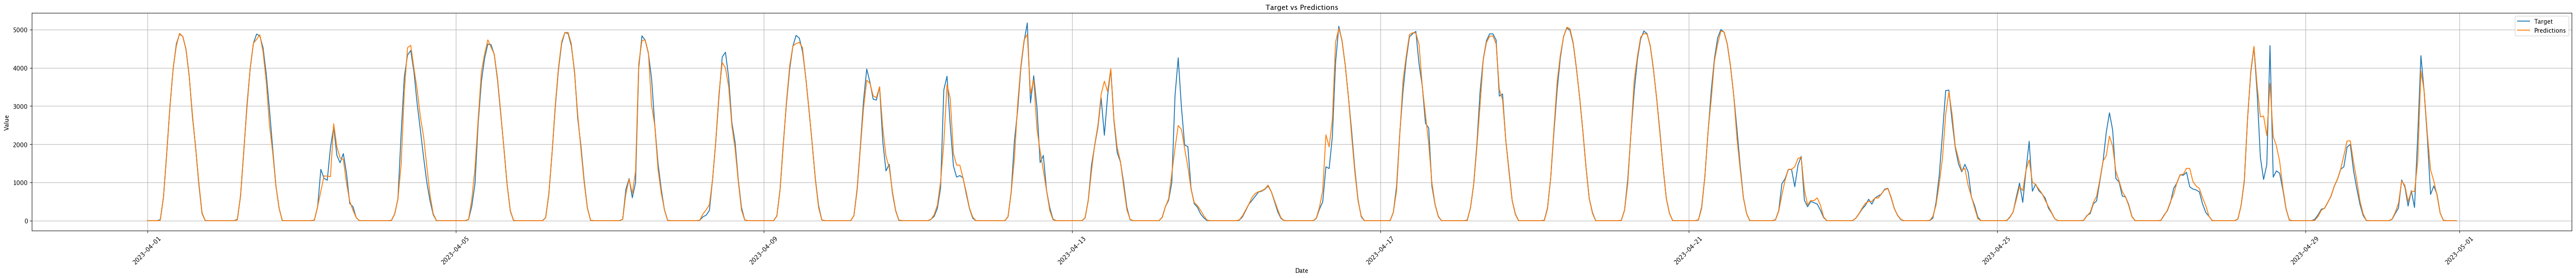

4394
4394
{'A': MinMaxScaler(), 'B': MinMaxScaler(), 'C': MinMaxScaler()}


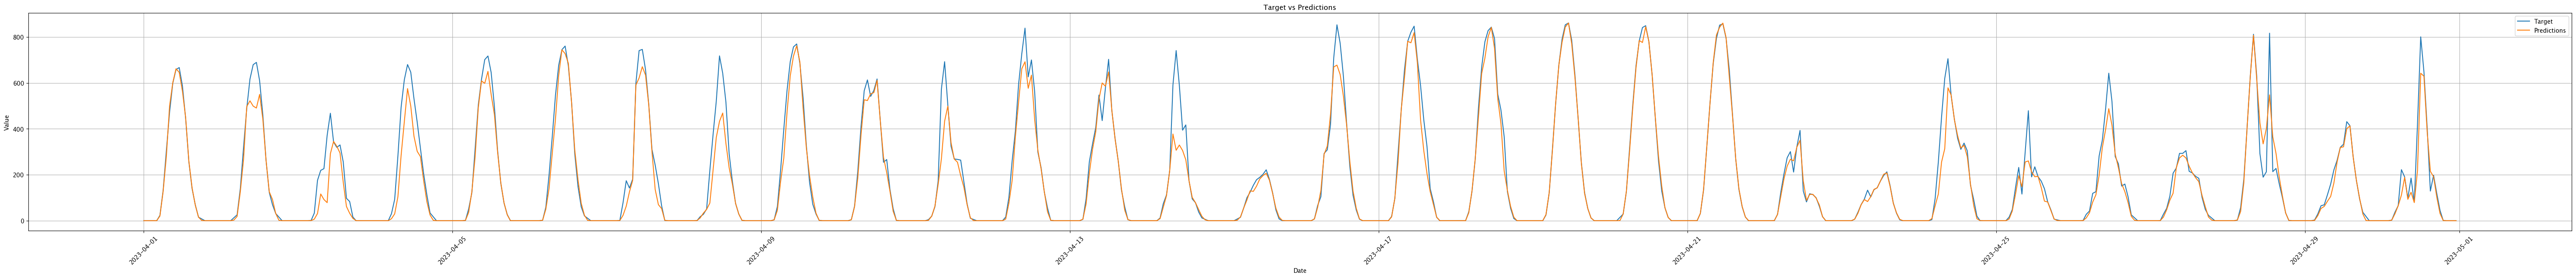

4394
4394
{'A': MinMaxScaler(), 'B': MinMaxScaler(), 'C': MinMaxScaler()}


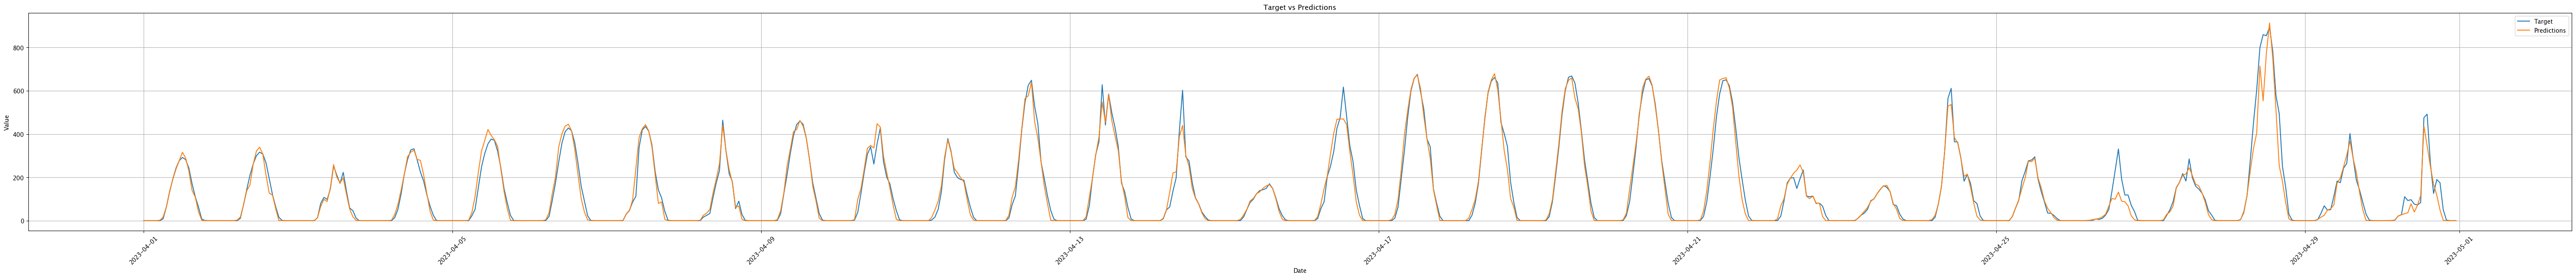

In [665]:
import matplotlib.pyplot as plt

def check_zeros_in_test_set(locations, data_folder="data"):
    # Dictionary to hold the count of zeros for each location
    zeros_count = {}

    # Iterate through each location
    for location in locations:
        # Load the test set data
        df_test = pd.read_parquet(f"{data_folder}/{location}/X_test_estimated.parquet")

        # Check for zeros in each column
        zeros_in_columns = (df_test == 0).sum()

        # Store the result in the dictionary
        zeros_count[location] = zeros_in_columns

    return zeros_count

# Assuming 'locations' is a list of location identifiers
locations = ["A", "B", "C"]
zero_values_summary = check_zeros_in_test_set(locations)


def evaluate_model_locally(location, scalers):
    # Load the test data
    target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    data = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")

    # Scale the data using the scaler for the current location
    
    # Make a copy of the date_forecast column
    dates = data["date_forecast"].copy()
    # Create a new DataFrame with dates as the index
    dates_df = pd.DataFrame(index=dates).tail(720*4)

    # Resample to 1-hour intervals
    resampled_dates = dates_df.resample('1H').asfreq().index

    # Make predictions
    preds = make_predictions(data, location, target)[-720:]
    # if location in scalers:
    #     # You need to reshape preds because inverse_transform expects a 2D array
    #     preds = preds.reshape(-1, 1)
    #     preds_original_scale = scalers[location].inverse_transform(preds)

    #     # Reshape preds back to its original shape if necessary
    #     preds_original_scale = preds_original_scale.flatten()
    # mae = mean_absolute_error(target, preds)
    # print(f"Mean average Error: {mae}")
    target = target.tail(720)["pv_measurement"].to_numpy()
    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(resampled_dates, target, label="Target")
    plt.plot(resampled_dates, preds, label="Predictions")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for loc in locations:
    evaluate_model_locally(loc, scalers)


## Submit to csv 1

In [664]:
df_submission = pd.read_csv("data/test.csv")

for location in locations: 
    df_test= pd.read_parquet(f"data/{location}/X_test_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    print(len(df_test))
    
    preds = make_predictions(df_test, location, df_target)
   
    # Assign the predictions to df_submission for the current location
    mask = df_submission["location"] == location
    print(len(mask))
    # Before this line in your main function

    # Add a check to make sure the lengths match
    if len(preds) != mask.sum():
        print(f"Length of predictions: {len(preds)}")
        print(f"Length of submission entries: {mask.sum()}")
        raise ValueError(f"Mismatch in length of predictions and submission entries for location {location}.")

    df_submission.loc[mask, "prediction"] = preds
    

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_8.csv", index=False)

2880
720
720
{'A': MinMaxScaler(), 'B': MinMaxScaler(), 'C': MinMaxScaler()}
2160
2880
720
720
{'A': MinMaxScaler(), 'B': MinMaxScaler(), 'C': MinMaxScaler()}
2160
2880
720
720
{'A': MinMaxScaler(), 'B': MinMaxScaler(), 'C': MinMaxScaler()}
2160


## Submit to csv

In [139]:
df_submission = pd.read_csv("data/test.csv")

df_test_merged = pd.DataFrame()
for location in locations: 
    df_test= pd.read_parquet(f"data/{location}/X_test_estimated.parquet")
    # df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    # df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    # df_test = pd.concat([df_observed, df_estimated, df_test_estimated], axis=0).sort_values(
    #     by="date_forecast"
    # )
    df_test_merged = pd.concat([df_test_merged, df_test])
    

# print(df_test_merged.head())
preds = make_predictions(df_test_merged, location, df_target)
df_submission["prediction"] = preds
# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_2.csv", index=False)

            date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1 2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2 2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3 2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4 2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.286            912.700012                    0.0   
1                1.287            912.700012                    0.0   
2                1.287            912.700012                    0.0   
3                1.287            912.700012                    0.0   
4                1.287                   NaN                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0              0.0       1041.199951              0.0      271.700012   


ValueError: Length of values (1536) does not match length of index (2160)